In [25]:
import numpy             as np
import pandas            as pd
import librosa
import torch
import matplotlib.pyplot as plt
import copy
import os
import torch.nn          as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from torch.utils.data      import DataLoader, Dataset, SubsetRandomSampler
from torch.nn.utils.rnn    import pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [26]:
# ΒΗΜΑ 1
dir_train_labels = '/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/train_labels.txt'
dir_train_data   = '/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms/train/'
train_labels     = pd.read_csv(dir_train_labels, sep='\t')


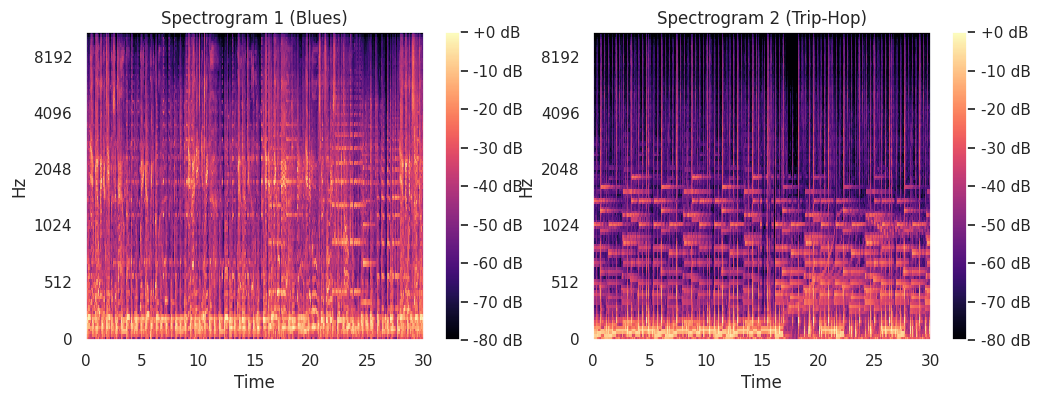

In [27]:
files       = []
mel_list    = []
chroma_list = []
id_list = ['1042.fused.full.npy','69588.fused.full.npy']
for i in range(len(id_list)):
    files.append(np.load(dir_train_data + id_list[i]))
    mel_list.append(files[i][:128])
    chroma_list.append(files[i][128:])
    
# Spectrogramms
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

img1 = librosa.display.specshow(mel_list[0], x_axis='time', y_axis='mel', ax=axes[0])
axes[0].set_title('Spectrogram 1 (Blues)')
fig.colorbar(img1, ax=axes[0], format="%+2.f dB")

img2 = librosa.display.specshow(mel_list[1], x_axis='time', y_axis='mel', ax=axes[1])
axes[1].set_title('Spectrogram 2 (Trip-Hop)')
fig.colorbar(img2, ax=axes[1], format="%+2.f dB")

Blues spectrogram timesteps = 1293
Trip-Hop spectrogram timesteps = 1293
Blues beat synced spectrogram timesteps = 62
Trip-Hop beat synced spectrogram timesteps = 87


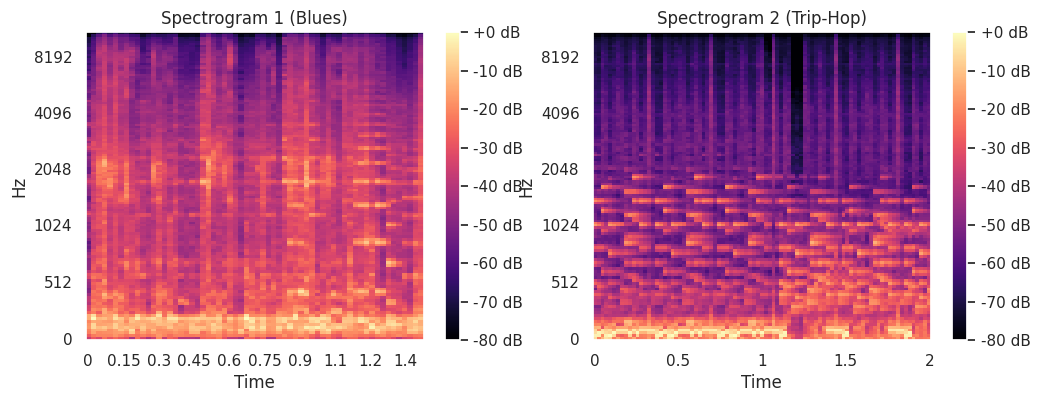

In [28]:
#ΒΗΜΑ 2
print('Blues spectrogram timesteps =', mel_list[0].shape[1])
print('Trip-Hop spectrogram timesteps =', mel_list[1].shape[1])

# Beat synced
dir_beat_train_labels = '/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/train_labels.txt'
dir_beat_train_data   = '/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat/train/'
beat_train_labels     = pd.read_csv(dir_beat_train_labels, sep='\t')
beat_files       = []
beat_mel_list    = []
beat_chroma_list = []
id_list = ['1042.fused.full.npy','69588.fused.full.npy']
for i in range(len(id_list)):
    beat_files.append(np.load(dir_beat_train_data + id_list[i]))
    beat_mel_list.append(beat_files[i][:128])
    beat_chroma_list.append(beat_files[i][128:])

print('Blues beat synced spectrogram timesteps =', beat_mel_list[0].shape[1])
print('Trip-Hop beat synced spectrogram timesteps =', beat_mel_list[1].shape[1])
# Beat_synced Spectrogramms
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

img1 = librosa.display.specshow(beat_mel_list[0], x_axis='time', y_axis='mel', ax=axes[0])
axes[0].set_title('Spectrogram 1 (Blues)')
fig.colorbar(img1, ax=axes[0], format="%+2.f dB")

img2 = librosa.display.specshow(beat_mel_list[1], x_axis='time', y_axis='mel', ax=axes[1])
axes[1].set_title('Spectrogram 2 (Trip-Hop)')
fig.colorbar(img2, ax=axes[1], format="%+2.f dB")

Blues chromagram timesteps = 1293
Trip-Hop chromagram timesteps = 1293
Blues chromagram beat synced timesteps = 62
Trip-Hop chromagram beat synced timesteps = 87


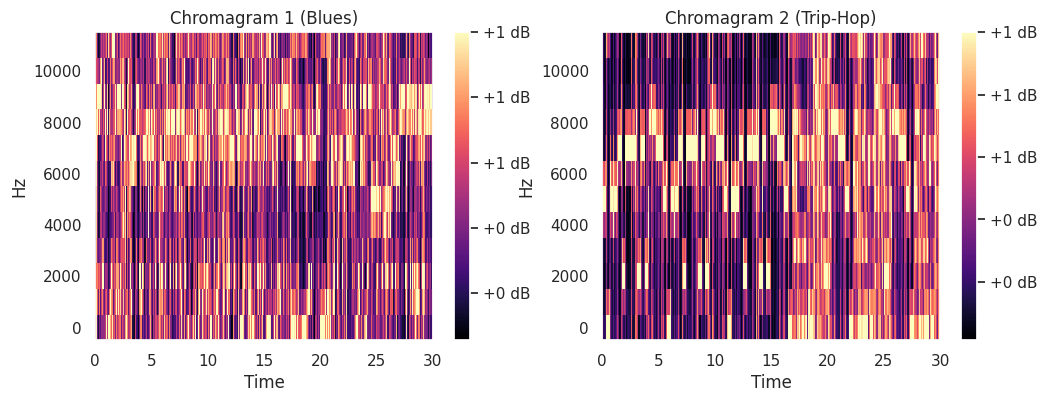

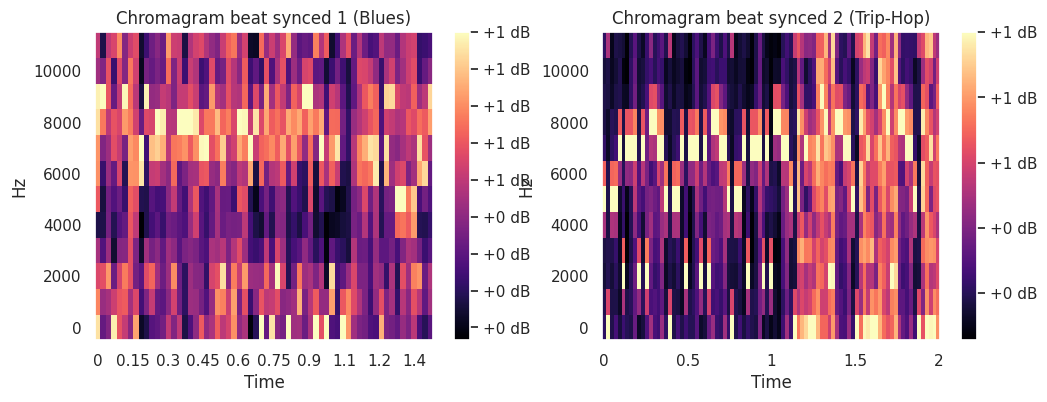

In [29]:
# ΒΗΜΑ 3

print('Blues chromagram timesteps =', chroma_list[0].shape[1])
print('Trip-Hop chromagram timesteps =', chroma_list[1].shape[1])
# Chromagrams
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

img1 = librosa.display.specshow(chroma_list[0], x_axis='time', y_axis='linear', ax=axes[0])
axes[0].set_title('Chromagram 1 (Blues)')
fig.colorbar(img1, ax=axes[0], format="%+2.f dB")

img2 = librosa.display.specshow(chroma_list[1], x_axis='time', y_axis='linear', ax=axes[1])
axes[1].set_title('Chromagram 2 (Trip-Hop)')
fig.colorbar(img2, ax=axes[1], format="%+2.f dB")

# Chromagrams beat synced
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

img1 = librosa.display.specshow(beat_chroma_list[0], x_axis='time', y_axis='linear', ax=axes[0])
axes[0].set_title('Chromagram beat synced 1 (Blues)')
fig.colorbar(img1, ax=axes[0], format="%+2.f dB")

img2 = librosa.display.specshow(beat_chroma_list[1], x_axis='time', y_axis='linear', ax=axes[1])
axes[1].set_title('Chromagram beat synced 2 (Trip-Hop)')
fig.colorbar(img2, ax=axes[1], format="%+2.f dB")

print('Blues chromagram beat synced timesteps =', beat_chroma_list[0].shape[1])
print('Trip-Hop chromagram beat synced timesteps =', beat_chroma_list[1].shape[1])

In [30]:
# ΒΗΜΑ 4
CLASS_MAPPING = {
    "Rock": "Rock",
    "Psych-Rock": "Rock",
    "Indie-Rock": None,
    "Post-Rock": "Rock",
    "Psych-Folk": "Folk",
    "Folk": "Folk",
    "Metal": "Metal",
    "Punk": "Metal",
    "Post-Punk": None,
    "Trip-Hop": "Trip-Hop",
    "Pop": "Pop",
    "Electronic": "Electronic",
    "Hip-Hop": "Hip-Hop",
    "Classical": "Classical",
    "Blues": "Blues",
    "Chiptune": "Electronic",
    "Jazz": "Jazz",
    "Soundtrack": None,
    "International": None,
    "Old-Time": None,
}

# edited so that we can use it for test dataset generation
def torch_train_val_split(dataset, batch_train, batch_eval, val_size=0.2, shuffle=True, seed=420, test_size=None):
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    if shuffle:
        np.random.seed(seed)
        np.random.shuffle(indices)
    
    if test_size:
        train_size = 1 - val_size - test_size
        train_split = int(np.floor(train_size * dataset_size))
        val_split = int(np.floor(val_size * dataset_size)) + train_split
        train_indices = indices[:train_split]
        val_indices = indices[train_split:val_split]
        test_indices = indices[val_split:]
        test_sampler = SubsetRandomSampler(test_indices)
        test_loader   = DataLoader(dataset, batch_size=batch_eval, sampler=test_sampler)
        
    else: 
        val_split = int(np.floor(val_size * dataset_size))
        train_indices = indices[val_split:]
        val_indices = indices[:val_split]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    train_loader = DataLoader(dataset, batch_size=batch_train, sampler=train_sampler)
    val_loader   = DataLoader(dataset, batch_size=batch_eval, sampler=val_sampler)
    
    if test_size:
        return train_loader, val_loader, test_loader
    return train_loader, val_loader

# edited so that we can get spectrogramms, chromagram or both
def read_spectrogram(spectrogram_file, spectype=None):
    # with open(spectrogram_file, "r") as f:
    spectrograms = np.load(spectrogram_file)
    # spectrograms contains a fused mel spectrogram and chromagram
    if spectype=='spectr':
        return spectrograms[:128].T
    elif spectype=='chroma':
        return spectrograms[128:].T
    return spectrograms.T

class LabelTransformer(LabelEncoder):
    def inverse(self, y):
        try:
            return super(LabelTransformer, self).inverse_transform(y)
        except:
            return super(LabelTransformer, self).inverse_transform([y])

    def transform(self, y):
        try:
            return super(LabelTransformer, self).transform(y)
        except:
            return super(LabelTransformer, self).transform([y])


class PaddingTransform(object):
    def __init__(self, max_length, padding_value=0):
        self.max_length = max_length
        self.padding_value = padding_value

    def __call__(self, s):
        if len(s) == self.max_length:
            return s

        if len(s) > self.max_length:
            return s[: self.max_length]

        if len(s) < self.max_length:
            s1 = copy.deepcopy(s)
            pad = np.zeros((self.max_length - s.shape[0], s.shape[1]), dtype=np.float32)
            s1 = np.vstack((s1, pad))
            return s1

# Fixed an issue for the access of the test labels
class SpectrogramDataset(Dataset):
    def __init__(
        self, path, class_mapping=None, train=True, max_length=-1, regression=None, spectype = None
    ):
        t = "train" if train else "test"
        p = os.path.join(path, t)
        self.regression = regression

        self.index = os.path.join(path, "{}_labels.txt".format(t))
        self.files, labels = self.get_files_labels(self.index, class_mapping)
        self.feats = [read_spectrogram(os.path.join(p, f), spectype) for f in self.files]
        self.feat_dim = self.feats[0].shape[1]
        self.lengths = [len(i) for i in self.feats]
        self.max_length = max(self.lengths) if max_length <= 0 else max_length
        self.zero_pad_and_stack = PaddingTransform(self.max_length)
        self.label_transformer = LabelTransformer()
        if isinstance(labels, (list, tuple)):
            if not regression:
                self.labels = np.array(
                    self.label_transformer.fit_transform(labels)
                ).astype("int64")
            else:
                self.labels = np.array(labels).astype("float64")

    def get_files_labels(self, txt, class_mapping):
        with open(txt, "r") as fd:
            lines = [l.rstrip().split("\t") for l in fd.readlines()[1:]]
        files, labels = [], []
        for l in lines:
            if self.regression:
                l = l[0].split(",")
                files.append(l[0] + ".fused.full.npy")
                if self.regression=='multitask':
                    valence, energy, danceability = map(float, l[-3:])
                    labels.append([valence, energy, danceability])
                else:
                    labels.append(l[self.regression])
                continue
            label = l[1]
            if class_mapping:
                label = class_mapping[l[1]]
            if not label:
                continue
#             fname = l[0]
#             if fname.endswith(".gz"):
#                 fname = ".".join(fname.split(".")[:-1])
#             files.append(fname)
#             print(fname)
            _id = l[0].split('.')[0]
            npy_file = '{}.fused.full.npy'.format(_id)
            ###########################################
            files.append(npy_file)
            labels.append(label)
        return files, labels

    def __getitem__(self, item):
        length = min(self.lengths[item], self.max_length)
        return self.zero_pad_and_stack(self.feats[item]), self.labels[item], length

    def __len__(self):
        return len(self.labels)


if __name__ == "__main__":
    dataset = SpectrogramDataset(
        "/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms", class_mapping=CLASS_MAPPING, train=True
    )

    print(dataset[10])
    print(f"Input: {dataset[10][0].shape}")
    print(f"Label: {dataset[10][1]}")
    print(f"Original length: {dataset[10][2]}")

(array([[-52.26681477, -52.71678237, -52.83256794, ...,   0.45063407,
          0.29996059,   0.29793641],
       [-45.12944043, -49.20641678, -51.77639735, ...,   0.53986666,
          0.38096958,   0.170305  ],
       [-44.2435711 , -42.88079978, -46.60278858, ...,   0.37760835,
          0.21692668,   0.24254749],
       ...,
       [-38.86648128, -42.70998466, -46.1181    , ...,   1.        ,
          0.30978935,   0.23961617],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]]), 0, 1291)
Input: (1293, 140)
Label: 0
Original length: 1291


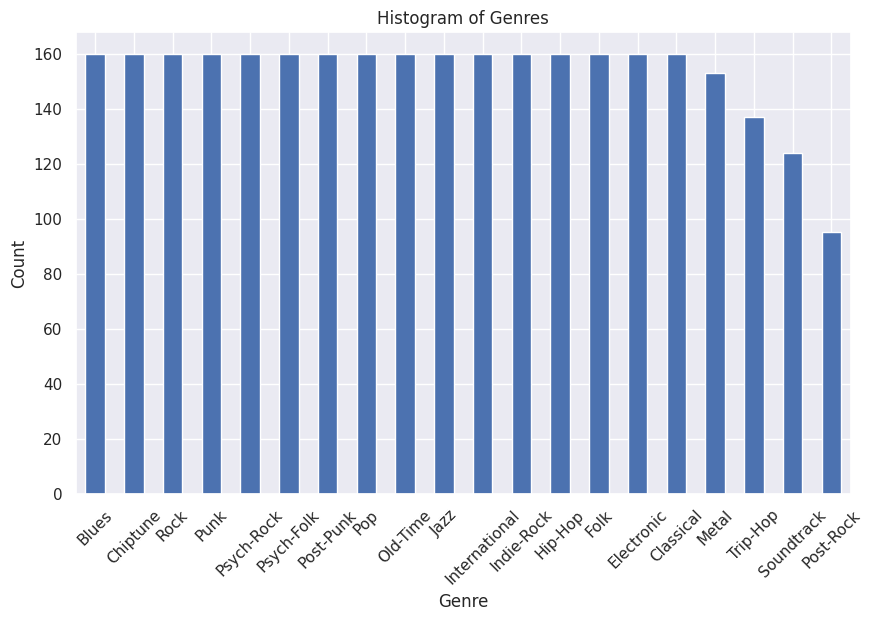

In [31]:
# Plot genres before grouping
genre_counts = train_labels['Genre'].value_counts()

# Plotting
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Histogram of Genres')
plt.xticks(rotation=45)
plt.show()

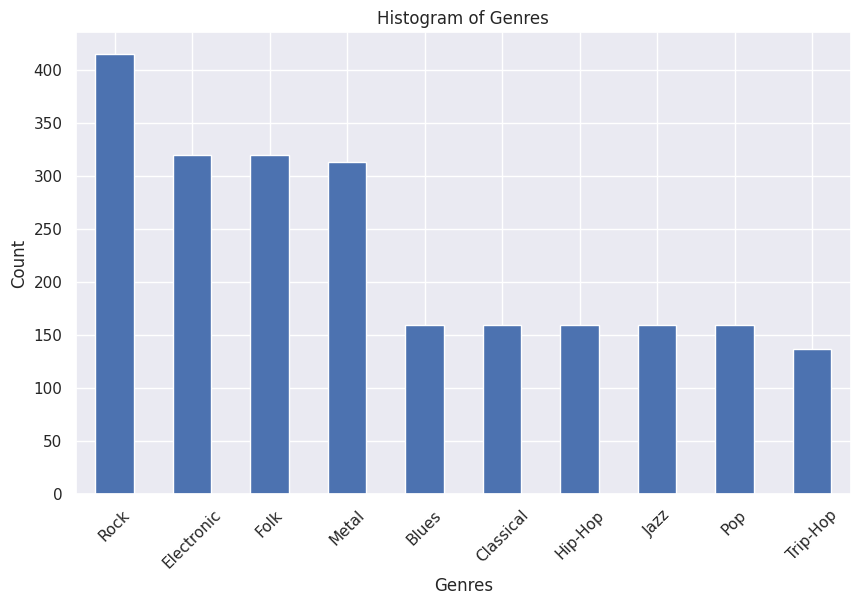

In [32]:
# plot after the grouping
grouped_classes = dataset.label_transformer.classes_.tolist()
index2genre = {}

for index, genre in enumerate(grouped_classes):
    index2genre[index] = genre

genres = [index2genre[spec[1]] for spec in dataset]

df = pd.DataFrame(genres, columns=['Genres'])

# Counting occurrences
category_counts = df['Genres'].value_counts()

# Plotting
plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar')
plt.xlabel('Genres')
plt.ylabel('Count')
plt.title('Histogram of Genres')
plt.xticks(rotation=45)
plt.show()

In [33]:
# ΒΗΜΑ 5

class PadPackedSequence(nn.Module):
    def __init__(self):
        """Wrap sequence padding in nn.Module
        Args:
            batch_first (bool, optional): Use batch first representation. Defaults to True.
        """
        super(PadPackedSequence, self).__init__()
        self.batch_first = True
        self.max_length = None

    def forward(self, x):
        """Convert packed sequence to padded sequence
        Args:
            x (torch.nn.utils.rnn.PackedSequence): Packed sequence
        Returns:
            torch.Tensor: Padded sequence
        """
        out, lengths = pad_packed_sequence(
            x, batch_first=self.batch_first, total_length=self.max_length  # type: ignore
        )
        lengths = lengths.to(out.device)
        return out, lengths  # type: ignore


class PackSequence(nn.Module):
    def __init__(self):
        """Wrap sequence packing in nn.Module
        Args:
            batch_first (bool, optional): Use batch first representation. Defaults to True.
        """
        super(PackSequence, self).__init__()
        self.batch_first = True

    def forward(self, x, lengths):
        """Pack a padded sequence and sort lengths
        Args:
            x (torch.Tensor): Padded tensor
            lengths (torch.Tensor): Original lengths befor padding
        Returns:
            Tuple[torch.nn.utils.rnn.PackedSequence, torch.Tensor]: (packed sequence, sorted lengths)
        """
        lengths = lengths.to("cpu")
        out = pack_padded_sequence(
            x, lengths, batch_first=self.batch_first, enforce_sorted=False
        )

        return out


class LSTMBackbone(nn.Module):
    def __init__(
        self,
        input_dim,
        rnn_size=128,
        num_layers=2,
        bidirectional=False,
        dropout=0.4,
    ):
        super(LSTMBackbone, self).__init__()
        self.batch_first = True
        self.bidirectional = bidirectional
        self.feature_size = rnn_size * 2 if self.bidirectional else rnn_size

        self.input_dim = input_dim
        self.rnn_size = rnn_size
        self.num_layers = num_layers
        self.hidden_size = rnn_size
        self.pack = PackSequence()
        self.unpack = PadPackedSequence()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=rnn_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=self.bidirectional,
            dropout=dropout,
        )
        self.drop = nn.Dropout(dropout)

    def forward(self, x, lengths):
        """LSTM forward
        Args:
            x (torch.Tensor):
                [B, S, F] Batch size x sequence length x feature size
                padded inputs
            lengths (torch.tensor):
                [B] Original lengths of each padded sequence in the batch
        Returns:
            torch.Tensor:
                [B, H] Batch size x hidden size lstm last timestep outputs
                2 x hidden_size if bidirectional
        """
        packed = self.pack(x, lengths)
        output, _ = self.lstm(packed)
        output, lengths = self.unpack(output)
        output = self.drop(output)

        rnn_all_outputs, last_timestep = self._final_output(output, lengths)
        # Use the last_timestep for classification / regression
        # Alternatively rnn_all_outputs can be used with an attention mechanism
        return last_timestep

    def _merge_bi(self, forward, backward):
        """Merge forward and backward states
        Args:
            forward (torch.Tensor): [B, L, H] Forward states
            backward (torch.Tensor): [B, L, H] Backward states
        Returns:
            torch.Tensor: [B, L, 2*H] Merged forward and backward states
        """
        return torch.cat((forward, backward), dim=-1)

    def _final_output(self, out, lengths):
        """Create RNN ouputs
        Collect last hidden state for forward and backward states
        Code adapted from https://stackoverflow.com/a/50950188
        Args:
            out (torch.Tensor): [B, L, num_directions * H] RNN outputs
            lengths (torch.Tensor): [B] Original sequence lengths
        Returns:
            Tuple[torch.Tensor, torch.Tensor]: (
                merged forward and backward states [B, L, H] or [B, L, 2*H],
                merged last forward and backward state [B, H] or [B, 2*H]
            )
        """

        if not self.bidirectional:
            return out, self._select_last_unpadded(out, lengths)

        forward, backward = (out[..., : self.hidden_size], out[..., self.hidden_size :])
        # Last backward corresponds to first token
        last_backward_out = backward[:, 0, :] if self.batch_first else backward[0, ...]
        # Last forward for real length or seq (unpadded tokens)
        last_forward_out = self._select_last_unpadded(forward, lengths)
        out = self._merge_bi(forward, backward)

        return out, self._merge_bi(last_forward_out, last_backward_out)

    def _select_last_unpadded(self, out, lengths):
        """Get the last timestep before padding starts
        Args:
            out (torch.Tensor): [B, L, H] Fprward states
            lengths (torch.Tensor): [B] Original sequence lengths
        Returns:
            torch.Tensor: [B, H] Features for last sequence timestep
        """
        gather_dim = 1  # Batch first
        gather_idx = (
            (lengths - 1)  # -1 to convert to indices
            .unsqueeze(1)  # (B) -> (B, 1)
            .expand((-1, self.hidden_size))  # (B, 1) -> (B, H)
            # (B, 1, H) if batch_first else (1, B, H)
            .unsqueeze(gather_dim)
        )
        # Last forward for real length or seq (unpadded tokens)
        last_out = out.gather(gather_dim, gather_idx).squeeze(gather_dim)

        return last_out

In [34]:
# 2D CNN

class CNNBackbone(nn.Module):
    def __init__(self, input_dims, in_channels, filters, feature_size):
        super(CNNBackbone, self).__init__()
        self.input_dims = input_dims
        self.in_channels = in_channels
        self.filters = filters
        self.feature_size = feature_size
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(self.in_channels, filters[0], kernel_size=(5,5), stride=1, padding=2),
            nn.BatchNorm2d((self.in_channels**1) * filters[0]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.conv2 = nn.Sequential(
                nn.Conv2d(filters[0], filters[1], kernel_size=(5,5), stride=1, padding=2),
                nn.BatchNorm2d((self.in_channels**2) * filters[1]),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.conv3 = nn.Sequential(
                nn.Conv2d(filters[1], filters[2], kernel_size=(3,3), stride=1, padding=1),
                nn.BatchNorm2d((self.in_channels**3) * filters[2]),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.conv4 = nn.Sequential(
                nn.Conv2d(filters[2], filters[3], kernel_size=(3,3), stride=1, padding=1),
                nn.BatchNorm2d((self.in_channels**4) * filters[3]),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
        )

        shape_after_convs = [input_dims[0]//2**(len(filters)), input_dims[1]//2**(len(filters))]
        self.fc1 = nn.Linear(filters[3] * shape_after_convs[0] * shape_after_convs[1], self.feature_size)
        
    def forward(self, x):
        """CNN forward
        Args:
            x (torch.Tensor):
                [B, S, F] Batch size x sequence length x feature size
                padded inputs
        Returns:
            torch.Tensor: [B, O] Batch size x CNN output size cnn outputs
        """
        x = x.view(x.shape[0], self.in_channels, x.shape[1], x.shape[2])
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        return out
        

In [35]:
def load_backbone_from_checkpoint(model, checkpoint_path):
    # Load the saved state dictionary
    checkpoint = torch.load(checkpoint_path)
    # Check if the checkpoint contains a specific key for model state
    if 'state_dict' in checkpoint:
        state_dict = checkpoint['state_dict']
    else:
        state_dict = checkpoint
    # Load the state dictionary into the model
    model.load_state_dict(state_dict)

    return model


class Classifier(nn.Module):
    def __init__(self, backbone, num_classes, load_from_checkpoint=None):
        """
        backbone (nn.Module): The nn.Module to use for spectrogram parsing
        num_classes (int): The number of classes
        load_from_checkpoint (Optional[str]): Use a pretrained checkpoint to initialize the model
        """
        super(Classifier, self).__init__()
        self.backbone = backbone  # An LSTMBackbone or CNNBackbone
        if load_from_checkpoint is not None:
            self.backbone = load_backbone_from_checkpoint(
                self.backbone, load_from_checkpoint
            )
        self.is_lstm = isinstance(self.backbone, LSTMBackbone)
        self.output_layer = nn.Linear(self.backbone.feature_size, num_classes)
        self.criterion = nn.CrossEntropyLoss()  # Loss function for classification

    def forward(self, x, targets, lengths):
        feats = self.backbone(x) if not self.is_lstm else self.backbone(x, lengths)
        logits = self.output_layer(feats)
        loss = self.criterion(logits, targets)
        return loss, logits

    
class Regressor(nn.Module):
    def __init__(self, backbone, load_from_checkpoint=None):
        """
        backbone (nn.Module): The nn.Module to use for spectrogram parsing
        load_from_checkpoint (Optional[str]): Use a pretrained checkpoint to initialize the model
        """
        super(Regressor, self).__init__()
        self.backbone = backbone  # An LSTMBackbone or CNNBackbone
        if load_from_checkpoint is not None:
            self.backbone = load_backbone_from_checkpoint(
                self.backbone, load_from_checkpoint
            )
        self.is_lstm = isinstance(self.backbone, LSTMBackbone)
        self.output_layer = nn.Linear(self.backbone.feature_size, 1)
        self.criterion = nn.MSELoss()  # Loss function for regression

    def forward(self, x, targets, lengths):
        feats = self.backbone(x) if not self.is_lstm else self.backbone(x, lengths)
        out = self.output_layer(feats)
        loss = self.criterion(out.float(), targets.float())
        return loss, out

# for step 10
class MultitaskLoss(nn.Module):
    def __init__(self, weights=None):
        super(MultitaskLoss, self).__init__()
        self.weights = weights if weights is not None else [1.0, 1.0, 1.0]

    def forward(self, logits, targets):
        valence_loss = nn.MSELoss()(logits[:, 0], targets[:, 0])
        energy_loss = nn.MSELoss()(logits[:, 1], targets[:, 1])
        danceability_loss = nn.MSELoss()(logits[:, 2], targets[:, 2])
        
        total_loss = self.weights[0] * valence_loss + self.weights[1] * energy_loss + self.weights[2] * danceability_loss
        return total_loss

# for step 10
class MultitaskRegressor(nn.Module):
    def __init__(self, backbone, load_from_checkpoint=None):
        super(MultitaskRegressor, self).__init__()
        self.backbone = backbone
        if load_from_checkpoint is not None:
            self.backbone = load_backbone_from_checkpoint(
                self.backbone, load_from_checkpoint
            )
        self.is_lstm = isinstance(self.backbone, LSTMBackbone)
        self.output_layer = nn.Linear(self.backbone.feature_size, 3) # Output layer for 3 tasks
        self.criterion = MultitaskLoss(weights=[1.0, 1.0, 1.0])
    def forward(self, x, targets, lengths):
        feats = self.backbone(x) if not self.is_lstm else self.backbone(x, lengths)
        out = self.output_layer(feats)
        loss = self.criterion(out.float(), targets.float())
        return loss, out


In [36]:
def save_checkpoint(model, filename="saved_model.pth"):
    state = {
        'state_dict': model.state_dict(),
    }
    torch.save(state, filename)


def training_loop(model, train_dataloader, optimizer, mode='classifier', device="cuda"):
    model.train()
    total_loss = 0
    for batch in train_dataloader:
        # Move batch to device
        inputs, targets, lengths = batch
        inputs = inputs.to(device).float()
        if mode=='classifier':
            targets = targets.to(device).long()
        elif mode=='regressor':
            targets = targets.to(device).float()
        lengths = lengths.to(device).float()
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        loss,_ = model(inputs, targets, lengths)
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_dataloader)


def validation_loop(model, val_dataloader,mode='classifier', device="cuda"):
    model.eval()
    total_loss = 0
    
    for batch in val_dataloader:
        inputs, targets, lengths = batch
        inputs = inputs.to(device).float()
        if mode=='classifier':
            targets = targets.to(device).long()
        elif mode=='regressor':
            targets = targets.to(device).float()
        lengths = lengths.to(device).float()
        
        loss, _ = model(inputs, targets, lengths)
        total_loss += loss.item()

    return total_loss / len(val_dataloader)


def test_loop(model, test_dataloader, mode='classifier', device="cuda"):
    model.eval()
    predictions = []
    y_true = []
    with torch.no_grad():
        for batch in test_dataloader:
            inputs, targets, lengths = batch
            inputs = inputs.to(device).float()
            lengths = lengths.to(device).float()
            
            if mode=='classifier':
                targets = targets.to(device).long()
                _, logits = model(inputs, targets, lengths)
                _, y_pred = torch.max(logits, dim=1)
                
            elif mode=='regressor':
                targets = targets.to(device).float()
                _, y_pred = model(inputs, targets, lengths)
            predictions.append(y_pred)
            y_true.append(targets)

    return predictions, y_true

def overfit_with_a_couple_of_batches(model, train_dataloader, device):
    epochs = 4000  # An absurd number of epochs
    few_batches = [next(iter(train_dataloader)) for _ in range(3)]
    printspace = (np.linspace(0,epochs,10)).astype(int)
    train_loss_list = []
    for epoch in range(epochs):  
        model.train()
        total_loss = 0
        for batch in few_batches:
            inputs, targets, lengths = batch
            inputs, targets = inputs.to(device).float(), targets.to(device).long()
            lengths = lengths.to(device).float()
            
            optimizer.zero_grad()
            
            loss, _ = model(inputs, targets, lengths)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if epoch%100==0:
            print(f'Epoch: {epoch}, Loss:{total_loss/len(few_batches)}')
        train_loss_list.append(total_loss/len(few_batches))

def train(model, train_dataloader, val_dataloader, optimizer, epochs, device, mode='classifier', overfit_batch=False):
    printspace = (np.linspace(0,epochs,10)).astype(int)
    if overfit_batch:
        overfit_with_a_couple_of_batches(model, train_dataloader, device)
    else:
        train_loss_list = []
        val_loss_list   = []
        epochs_no_improve = 0
        for epoch in range(epochs):
            train_loss = training_loop(model, train_dataloader, optimizer, mode, device)
            val_loss = validation_loop(model, val_dataloader, mode, device)
            train_loss_list.append(train_loss)
            val_loss_list.append(val_loss)
            if epoch in printspace:
                print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
            # TODO: early stopping
            # Check if the validation loss improved
            best_val_loss = 10**6
            patience = 3
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_no_improve = 0  # Reset counter if there is an improvement
                save_checkpoint(model)
            else:
                epochs_no_improve += 1  # Increment counter if no improvement

            # Early stopping check
            if epochs_no_improve >= patience:
                print(f'Early stopping triggered after {epoch + 1} epochs')
                break
                
        return train_loss_list,val_loss_list

In [37]:
# print classification report
def predict_and_scores(test_path, spectype, mode='classifier'):
    
    test_dataset = SpectrogramDataset(test_path, class_mapping=CLASS_MAPPING, train=False, spectype = spectype)
    test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    predictions, y_true = test_loop(model, test_dataloader, device="cuda")
    predictions = torch.cat(predictions, dim=0)
    y_true = torch.cat(y_true, dim=0)

    if mode=='classifier':
        c = classification_report(y_true.cpu(),predictions.cpu())
        print(c)

# print spearman correlation
def predict_and_corr(test_dataloader, multitask=None):
    predictions, y_true = test_loop(model, test_dataloader, mode='regressor', device="cuda")
    predictions = torch.cat(predictions, dim=0)
    y_true = torch.cat(y_true, dim=0)
    if multitask:
        spearman_correlation = [0,0,0]
        for i in range(3):
            spearman_correlation[i] = spearmanr(y_true[:,i].cpu(), predictions[:,i].cpu()).correlation
    else:
        spearman_correlation = spearmanr(y_true.cpu(), predictions.cpu()).correlation
    print(f'Spearman Correlation: {spearman_correlation}')

# plot losses over time
def plot_loss(train_losses, val_losses, mode='classifier', task=None):
    num_epochs = [i for i in range(len(train_losses))]
    plt.plot(num_epochs, train_losses, label='Training Loss')
    plt.plot(num_epochs, val_losses, label='Validation Loss')
    if mode=='classifier':
        plt.title(f'Losses over epochs')
    elif mode=='regressor':
        plt.title(f'Losses over epochs for {task}')
    elif mode=='multitask':
        plt.title(f'Losses over epochs for valence+energy+danceability')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

In [38]:
hyperparams = {
    "epochs":100,
    "learning_rate":1e-5,
    "weight_decay": 1e-6,
    }
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# train, test, classification report for mel spectrograms
path = "/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms"
spectype = "spectr"
# train, validations
epochs = hyperparams["epochs"]
weight_decay = hyperparams["weight_decay"]
learning_rate = hyperparams["learning_rate"]
backbone  = LSTMBackbone(input_dim = 128)
model     = Classifier(backbone, num_classes = 10, ).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

spectr_dataset = SpectrogramDataset(path, class_mapping=CLASS_MAPPING, train=True, spectype = spectype)
train_dataloader, val_dataloader=torch_train_val_split(spectr_dataset, batch_train=32, batch_eval=32, val_size=0.2, shuffle=True)
train_loss, val_loss = train(model, train_dataloader, val_dataloader, optimizer, epochs, DEVICE, overfit_batch=False)

# test+predict on test set
plot_loss(train_loss, val_loss)
predict_and_scores(test_path=path,spectype=spectype)

In [ ]:
# train, test, classification report for beat_synced mel spectrograms
path = "/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms_beat"
spectype = "spectr"
# train, validations
epochs = hyperparams["epochs"]
weight_decay = hyperparams["weight_decay"]
learning_rate = hyperparams["learning_rate"]
backbone  = LSTMBackbone(input_dim = 128)
model     = Classifier(backbone, num_classes = 10, ).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

spectr_dataset = SpectrogramDataset(path, class_mapping=CLASS_MAPPING, train=True, spectype = spectype)
train_dataloader, val_dataloader=torch_train_val_split(spectr_dataset, batch_train=32, batch_eval=32, val_size=0.2, shuffle=True)
train_loss, val_loss = train(model, train_dataloader, val_dataloader, optimizer, epochs, DEVICE, overfit_batch=False)

# test+predict on test set
plot_loss(train_loss, val_loss)
predict_and_scores(test_path=path,spectype=spectype)

In [ ]:
# train, test, classification report for chromagrams
path = "/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms"
spectype = "chroma"
# train, validations
epochs = hyperparams["epochs"]
weight_decay = hyperparams["weight_decay"]
learning_rate = hyperparams["learning_rate"]
backbone  = LSTMBackbone(input_dim = 12)
model     = Classifier(backbone, num_classes = 10, ).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

chroma_dataset = SpectrogramDataset(path, class_mapping=CLASS_MAPPING, train=True, spectype = spectype)
train_dataloader, val_dataloader=torch_train_val_split(chroma_dataset, batch_train=32, batch_eval=32, val_size=0.2, shuffle=True)
train_loss, val_loss = train(model, train_dataloader, val_dataloader, optimizer, epochs, DEVICE, overfit_batch=False)

# test+predict on test set
plot_loss(train_loss, val_loss)
predict_and_scores(test_path=path,spectype=spectype)

In [ ]:
# train, test, classification report for both mel and chroma
path = "/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms"
spectype = "both"
# train, validations
epochs = hyperparams["epochs"]
weight_decay = hyperparams["weight_decay"]
learning_rate = hyperparams["learning_rate"]
backbone  = LSTMBackbone(input_dim = 140)
model     = Classifier(backbone, num_classes = 10, ).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

dataset = SpectrogramDataset(path, class_mapping=CLASS_MAPPING, train=True, spectype = spectype)
train_dataloader, val_dataloader = torch_train_val_split(dataset, batch_train=32, batch_eval=32, val_size=0.2, shuffle=True)
train_loss, val_loss = train(model, train_dataloader, val_dataloader, optimizer, epochs, DEVICE, overfit_batch=False)

# test+predict on test set
plot_loss(train_loss, val_loss)
predict_and_scores(test_path=path,spectype=spectype)

In [ ]:
# run Training in overfitting mode for the CNN
NUM_CATEGORIES = 10
cnn_in_channels = 1
cnn_filters = [32, 64, 128, 256]
cnn_out_feature_size = 1000
spectype = "spectr"
LR = 1e-4
epochs = 10
path = "/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms"

dataset = SpectrogramDataset(path, class_mapping=CLASS_MAPPING, train=True, spectype = spectype)
train_dataloader, val_dataloader = torch_train_val_split(dataset, batch_train=32, batch_eval=32, val_size=0.2, shuffle=True)

# get the input shape
x_b1, y_b1, lengths_b1 = next(iter(train_dataloader))
input_shape = x_b1[0].shape

backbone = CNNBackbone(input_shape, cnn_in_channels, cnn_filters, cnn_out_feature_size)
model = Classifier(backbone, NUM_CATEGORIES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

train_loss, val_loss = train(model, train_dataloader, val_dataloader, optimizer, epochs, DEVICE, overfit_batch=True)
plot_loss(train_loss, val_loss)


In [ ]:
# run Training for the CNN, for spectrograms
NUM_CATEGORIES = 10
cnn_in_channels = 1
cnn_filters = [32, 64, 128, 256]
cnn_out_feature_size = 1000
spectype = "spectr"
LR = 1e-5
epochs = 20
path = "/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms"

dataset = SpectrogramDataset(path, class_mapping=CLASS_MAPPING, train=True, spectype = spectype)
train_dataloader, val_dataloader = torch_train_val_split(dataset, batch_train=32, batch_eval=32, val_size=0.35, shuffle=True)

# get the input shape
x_b1, y_b1, lengths_b1 = next(iter(train_dataloader))
input_shape = x_b1[0].shape

backbone = CNNBackbone(input_shape, cnn_in_channels, cnn_filters, cnn_out_feature_size, dropout_rate=DROPOUT_RATE)
model = Classifier(backbone, NUM_CATEGORIES).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
train_loss, val_loss = train(model, train_dataloader, val_dataloader, optimizer, epochs, DEVICE, overfit_batch=False)
# test+predict on test set
plot_loss(train_loss, val_loss)
predict_and_scores(test_path=path,spectype=spectype)

In [ ]:
# ΒΗΜΑ 8
# LSTM for beat_synced spectrogram for multitask_dataset using regression
tasks = ['valence', 'energy', 'danceability']
spectype = 'spectr'
epochs = 20
weight_decay = hyperparams["weight_decay"]
learning_rate = hyperparams["learning_rate"]

for task in tasks:
    print(f'Training LSTM regressor using beat_synced spectrogram and {task} labels')
    label_index = tasks.index(task) + 1
    dataset = SpectrogramDataset(
        '/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset_beat', 
        train=True, spectype=spectype, regression=label_index)
    train_dataloader, val_dataloader, test_dataloader = torch_train_val_split(dataset, batch_train=32, batch_eval=32, test_size=0.1)
    # train, validations
    backbone  = LSTMBackbone(input_dim = 128)
    model     = Regressor(backbone).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    train_loss, val_loss = train(model, train_dataloader, val_dataloader, optimizer, epochs, DEVICE, mode='regressor', overfit_batch=False)
    # test+predict on test set
    predict_and_corr(test_dataloader)
    plot_loss(train_loss, val_loss, mode='regressor', task=task)

In [ ]:
# CNN for beat_synced spectrogram for multitask_dataset using regression
tasks = ['valence', 'energy', 'danceability']
spectype='spectr'
epochs = 20
learning_rate = 1e-3
cnn_in_channels = 1
cnn_filters = [4, 8, 12, 16]
cnn_out_feature_size = 1000

for task in tasks:
    print(f'Training CNN regressor using beat_synced spectrogram and {task} labels')
    label_index = tasks.index(task) + 1
    dataset = SpectrogramDataset(
        '/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset_beat', 
        train=True, spectype=spectype, regression=label_index)
    train_dataloader, val_dataloader, test_dataloader = torch_train_val_split(dataset, batch_train=32, batch_eval=32, test_size=0.1)
    # get the input shape
    x_b1, y_b1, lengths_b1 = next(iter(train_dataloader))
    input_shape = x_b1[0].shape
    # train, validations
    backbone  = CNNBackbone(input_shape, cnn_in_channels, cnn_filters, cnn_out_feature_size)
    model     = Regressor(backbone).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    train_loss, val_loss = train(model, train_dataloader, val_dataloader, optimizer, epochs, DEVICE, mode='regressor', overfit_batch=False)
    # test+predict on test set
    predict_and_corr(test_dataloader)


Epoch 1, Train Loss: 4.1519, Validation Loss: 2.2330
Epoch 2, Train Loss: 1.7434, Validation Loss: 2.0660
Epoch 3, Train Loss: 1.2685, Validation Loss: 1.8370
Epoch 4, Train Loss: 0.9263, Validation Loss: 2.1237
Epoch 5, Train Loss: 0.6921, Validation Loss: 1.7274
Epoch 6, Train Loss: 0.4332, Validation Loss: 1.9379
Epoch 7, Train Loss: 0.3065, Validation Loss: 1.9325
Epoch 8, Train Loss: 0.2005, Validation Loss: 1.5843
Epoch 9, Train Loss: 0.1407, Validation Loss: 1.6550


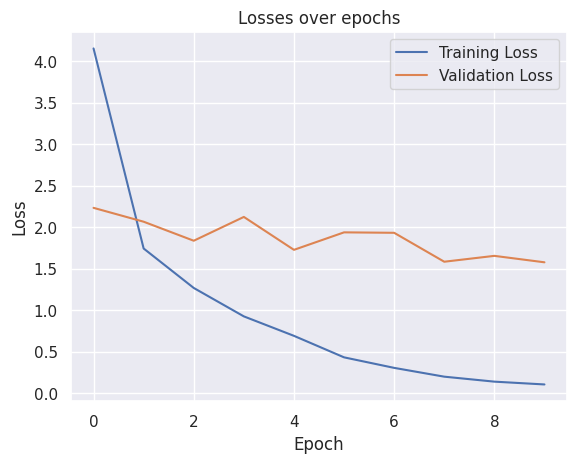

              precision    recall  f1-score   support

           0       0.38      0.25      0.30        40
           1       0.58      0.62      0.60        40
           2       0.59      0.53      0.56        80
           3       0.45      0.60      0.52        80
           4       0.47      0.60      0.53        40
           5       0.19      0.15      0.17        40
           6       0.50      0.71      0.59        78
           7       0.10      0.03      0.04        40
           8       0.43      0.37      0.40       103
           9       0.32      0.35      0.33        34

    accuracy                           0.45       575
   macro avg       0.40      0.42      0.40       575
weighted avg       0.43      0.45      0.43       575

Training RNN regressor using spectrogram and valence labels


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([17])) that is different to the input size (torch.Size([17, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Train Loss: 4041.7610, Validation Loss: 439.6961
Epoch 2, Train Loss: 166.1258, Validation Loss: 63.8556
Epoch 3, Train Loss: 16.7989, Validation Loss: 9.0405
Epoch 4, Train Loss: 4.2676, Validation Loss: 1.9790
Epoch 5, Train Loss: 2.0035, Validation Loss: 1.3430
Spearman Correlation: 0.022253042588061694


In [40]:
# BHMA 9
# ekpaideuoume to CNN classifier
NUM_CATEGORIES = 10
cnn_in_channels = 1
cnn_filters = [32, 64, 128, 256]
cnn_out_feature_size = 1000
spectype = "spectr"
LR = 1e-5
epochs = 10
path = "/kaggle/input/patreco3-multitask-affective-music/data/fma_genre_spectrograms"

dataset = SpectrogramDataset(path, class_mapping=CLASS_MAPPING, train=True, spectype = spectype)
train_dataloader, val_dataloader = torch_train_val_split(dataset, batch_train=32, batch_eval=32, val_size=0.35, shuffle=True)

# get the input shape
x_b1, y_b1, lengths_b1 = next(iter(train_dataloader))
input_shape = x_b1[0].shape
backbone = CNNBackbone(input_shape, cnn_in_channels, cnn_filters, cnn_out_feature_size)
model = Classifier(backbone, NUM_CATEGORIES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
train_loss, val_loss = train(model, train_dataloader, val_dataloader, optimizer, epochs, DEVICE, overfit_batch=False)
# test+predict on test set
plot_loss(train_loss, val_loss)
predict_and_scores(test_path=path,spectype=spectype)

# CNN regressor for valence from checkpoint
cnn_in_channels = 1
cnn_filters = [32, 64, 128, 256]
cnn_out_feature_size = 1000
spectype = "spectr"
LR = 1e-4
epochs = 10

source_model_path = '/kaggle/working/saved_model.pth'
source_model = torch.load(source_model_path)
backbone = CNNBackbone(input_shape, cnn_in_channels, cnn_filters, cnn_out_feature_size)
model = Regressor(backbone).to(DEVICE)
del source_model['state_dict']['output_layer.weight']
del source_model['state_dict']['output_layer.bias']
model.load_state_dict(source_model, strict=False)
model.to(DEVICE)

path = "/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset"
tasks = ['valence', 'energy', 'danceability']
task='valence'
print(f'Training CNN regressor using spectrogram and {task} labels')
label_index = tasks.index(task) + 1

dataset = SpectrogramDataset(path, train=True, spectype=spectype, regression=label_index)
train_dataloader, val_dataloader, test_dataloader = torch_train_val_split(dataset, batch_train=32, batch_eval=32, test_size=0.1)
# get the input shape
x_b1, y_b1, lengths_b1 = next(iter(train_dataloader))
input_shape = x_b1[0].shape

# train, validations
optimizer = optim.Adam(model.parameters(), lr=LR)
train_loss, val_loss = train(model, train_dataloader, val_dataloader, optimizer, epochs, DEVICE, mode='regressor', overfit_batch=False)
# test+predict on test set
predict_and_corr(test_dataloader)

Epoch 1, Train Loss: 55.9349, Validation Loss: 1.4812
Epoch 2, Train Loss: 4.1229, Validation Loss: 2.4832
Epoch 3, Train Loss: 0.6986, Validation Loss: 0.3480
Epoch 4, Train Loss: 0.3124, Validation Loss: 0.2083
Epoch 5, Train Loss: 0.1760, Validation Loss: 0.2130
Epoch 6, Train Loss: 0.1447, Validation Loss: 0.1579
Epoch 7, Train Loss: 0.1345, Validation Loss: 0.1897
Epoch 8, Train Loss: 0.1047, Validation Loss: 0.1722
Epoch 9, Train Loss: 0.0899, Validation Loss: 0.2080
Spearman Correlation: [0.3584232819168891, 0.5121506443388644, 0.4133385178308032]


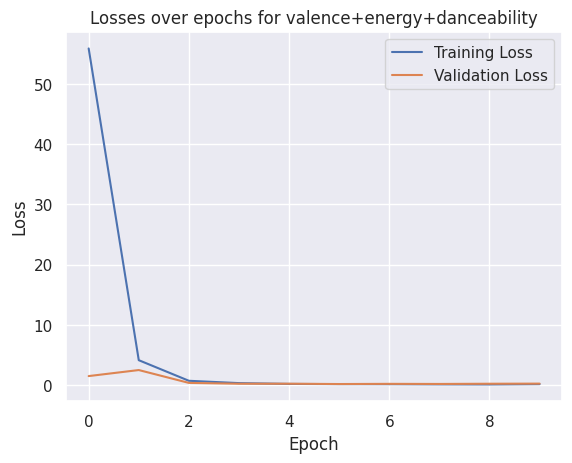

In [42]:
# BHMA 10
cnn_in_channels = 1
cnn_filters = [32, 64, 128, 256]
cnn_out_feature_size = 1000
spectype = "spectr"
learning_rate = hyperparams["learning_rate"]
epochs = 10
spectype='spectr'
weight_decay = hyperparams["weight_decay"]

path = "/kaggle/input/patreco3-multitask-affective-music/data/multitask_dataset"
dataset = SpectrogramDataset(path, train=True, spectype=spectype, regression='multitask')
train_dataloader, val_dataloader, test_dataloader = torch_train_val_split(dataset, batch_train=32, batch_eval=32, test_size=0.1)
x_b1, y_b1, lengths_b1 = next(iter(train_dataloader))
input_shape = x_b1[0].shape

backbone  = CNNBackbone(input_shape, cnn_in_channels, cnn_filters, cnn_out_feature_size)
model     = MultitaskRegressor(backbone).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay = weight_decay)

train_loss, val_loss = train(model, train_dataloader, val_dataloader, optimizer, epochs, DEVICE, mode='regressor', overfit_batch=False)
predict_and_corr(test_dataloader, multitask=True)
plot_loss(train_loss, val_loss, mode='multitask')